# Model the Clusters Using Different Models

## Import Libraries

In [1]:
# Import the required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

import warnings
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
warnings.filterwarnings("ignore")

import random
random.seed(42)

## Read the Data

In [2]:
# Read the CSV file
final_df = pd.read_csv('averaged_final_2.csv')

## Clean the Data

In [3]:
# Convert the 'change' column to string
final_df['change'] = final_df['change'].astype(str)

In [4]:
# Drop the 'Unnamed: 0' column
final_df = final_df.drop(columns=['Unnamed: 0'])

In [5]:
# Convert the 'change' column to boolean
final_df['change'] = final_df['change'].apply(lambda x: 1 if x == "True" else 0)

## Logistic Regression Model

In [7]:
# Define functions
def log_regression(x, y, plot=False):
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

    # Standardize features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Encode labels (for categorical y)
    label_encoder = LabelEncoder()
    y_train_encoded = label_encoder.fit_transform(y_train)
    y_test_encoded = label_encoder.transform(y_test)

    # Train Logistic Regression model
    model = LogisticRegression(max_iter=500)
    model.fit(X_train_scaled, y_train_encoded)

    # Model accuracy
    accuracy = model.score(X_test_scaled, y_test_encoded)

    # Permutation importance
    perm_imp = permutation_importance(model, X_test_scaled, y_test_encoded, scoring='accuracy', n_repeats=10, random_state=42)

    # Fix sorting issue
    feature_importance = np.abs(perm_imp.importances_mean)  # Take absolute values
    feature_names = np.array(x.columns)  # Ensure it's an array
    sorted_idx = np.argsort(-feature_importance)  # Sort in descending order

    # Create DataFrame for readability
    perm_df = pd.DataFrame({'feature': feature_names[sorted_idx], 'importance': feature_importance[sorted_idx]})

    # Plot Feature Importance
    if plot:
        plt.figure(figsize=(10, 5))
        plt.bar(range(len(sorted_idx)), feature_importance[sorted_idx], align="center")
        plt.xticks(range(len(sorted_idx)), feature_names[sorted_idx], rotation=90)
        plt.xlabel('Features')
        plt.ylabel('Importance')
        plt.title('Feature Importance for Logistic Regression')
        plt.show()

    important_features = feature_names[sorted_idx].tolist()

    #print("Accuracy for Logistic Regression:", accuracy)
    
    return model, accuracy, important_features


## Random Forest Model

In [8]:
# Define functions
def rfc(x, y, plot):
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.15, random_state=42)


    label_encoder = LabelEncoder()
    y_train_encoded = label_encoder.fit_transform(y_train)
    y_test_encoded = label_encoder.transform(y_test)

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)


    best_accuracy = 0
    best_model = None
    for _ in range(100):
        model = RandomForestClassifier()
        model.fit(X_train, y_train_encoded)
        acc = model.score(X_test, y_test_encoded)
        if acc > best_accuracy:
            best_accuracy = acc
            best_model = model
    model_RFC = best_model
    accuracy_RFC = best_accuracy

    


    feature_importance = np.abs(model_RFC.feature_importances_)
    sorted_idx = np.argsort(feature_importance)[::-1]

    # Retrieve column names before scaling
    feature_names = x.columns
    

    if plot==True:

        plt.figure(figsize=(10, 5))
        plt.bar(range(len(feature_importance)), feature_importance[sorted_idx])
        plt.xticks(range(len(feature_importance)), feature_names[sorted_idx], rotation=90)
        plt.xlabel('Features')
        plt.ylabel('Importance')
        plt.title('Feature Importance for RFC')
        plt.show()
    important_features = feature_names[sorted_idx].tolist()
    #print("Accuracy for Random Forest Classifier:", accuracy_RFC)
    return model_RFC, accuracy_RFC, important_features

In [9]:
# Define function
def choose_lowest_error_features(x, y, model_to_fit):
    
    if model_to_fit == 'rfc':
        func=rfc
        name="Random Forest Classifier"
    elif model_to_fit == 'log':
        func=log_regression
        name="Logistic Regression"
    else:
        print("Invalid model name. Please choose 'rfc' or 'log'.")
    model, accuracy, important_features = func(x, y, False)
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=49)
    accuracy_list = {}
    max_features = len(important_features)
    for i in range(1, max_features):
          # Ensure we don't exceed available features
        _, acc, _ = func(x[important_features[:i+1]], y, False)
        #print("Accuracy:", acc)
        accuracy_list[i+1] = acc
        #print("Number of Features:", i+1)
# Find the maximum accuracy value
    max_accuracy = max(accuracy_list.values())

    # Get all feature counts that achieve this max accuracy
    best_feature_counts = [k for k, v in accuracy_list.items() if v == max_accuracy]

    # Choose the largest number of features among them
    best_num_features = max(best_feature_counts)
    best_accuracy = accuracy_list[best_num_features]
    best_features = important_features[:best_num_features]
    print("Using the model:", name)
    print(f"Maximum accuracy: {best_accuracy:.4f} with the features: {best_features}")
    print(f"Choosing the first {best_num_features} features")   

## XGBoost Model

In [28]:
# Define function
def xgboost_model(x, y):
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=42)

    # Train XGBoost model
    best_accuracy = 0
    best_model = None
    for _ in range(100):
        model = xgb.XGBClassifier()
        model.fit(X_train, y_train)
        acc = model.score(X_test, y_test)
        if acc > best_accuracy:
            best_accuracy = acc
            best_model = model




    print("Accuracy for XGBoost:", best_accuracy)

In [11]:
# Define variables
cluster1_list = ['Australia', 'Austria', 'Belgium', 'Czechia', 'Denmark', 'France', 'Germany', 'Greece', 'Iceland', 'Israel', 'Italy']
cluster2_list = ['Colombia', 'Mexico', 'Turkey']
cluster3_list = ['Chile', 'Costa Rica', 'Estonia', 'Hungary', 'Ireland', 'Latvia', 'Lithuania', 'Poland', 'Portugal', 'Slovenia', 'South Korea']
cluster4_list = ['Canada', 'Finland', 'Japan', 'Luxembourg', 'Netherlands', 'New Zealand', 'Norway', 'Spain', 'Sweden', 'Switzerland', 'United Kingdom', 'United States']

cluster1_df = final_df[final_df['country'].isin(cluster1_list)]
cluster2_df = final_df[final_df['country'].isin(cluster2_list)]
cluster3_df = final_df[final_df['country'].isin(cluster3_list)]
cluster4_df = final_df[final_df['country'].isin(cluster4_list)]

## View Model Results

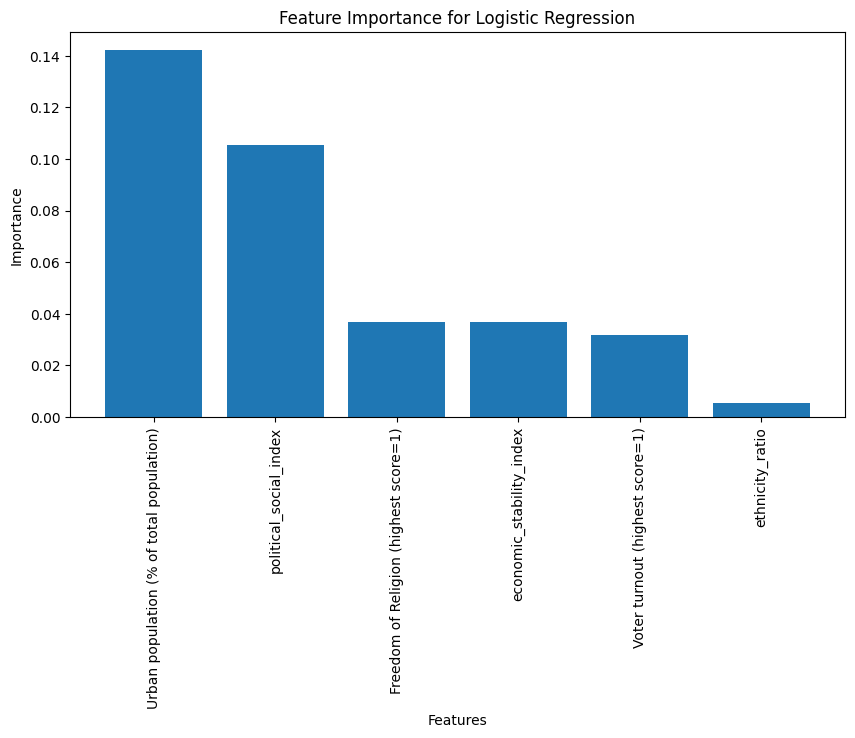

Cluster 1 accuracy with Logistic Regression: 0.3157894736842105


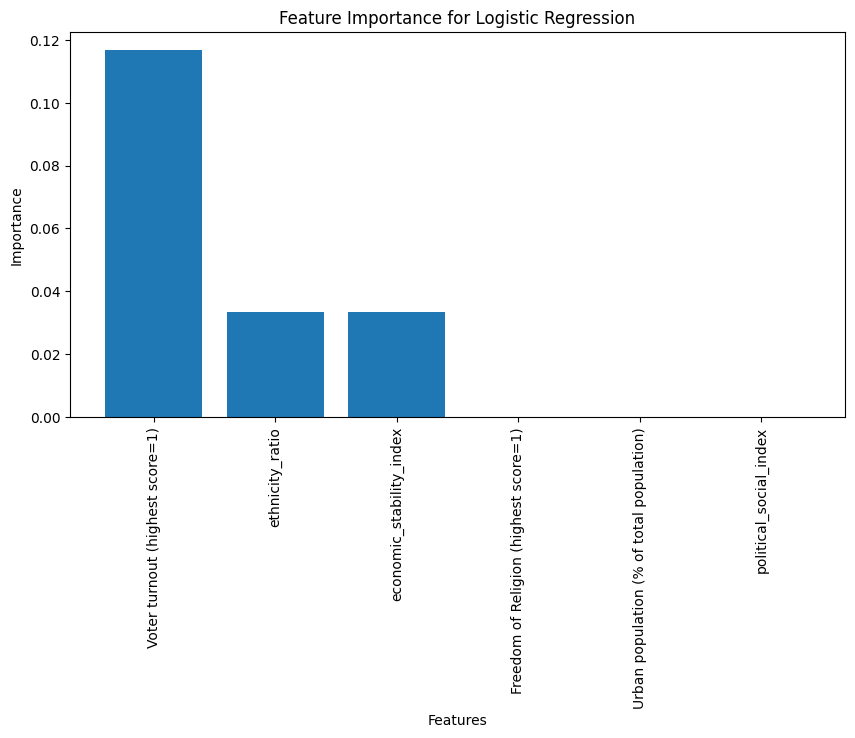

Cluster 2 accuracy with Logistic Regression: 0.3333333333333333


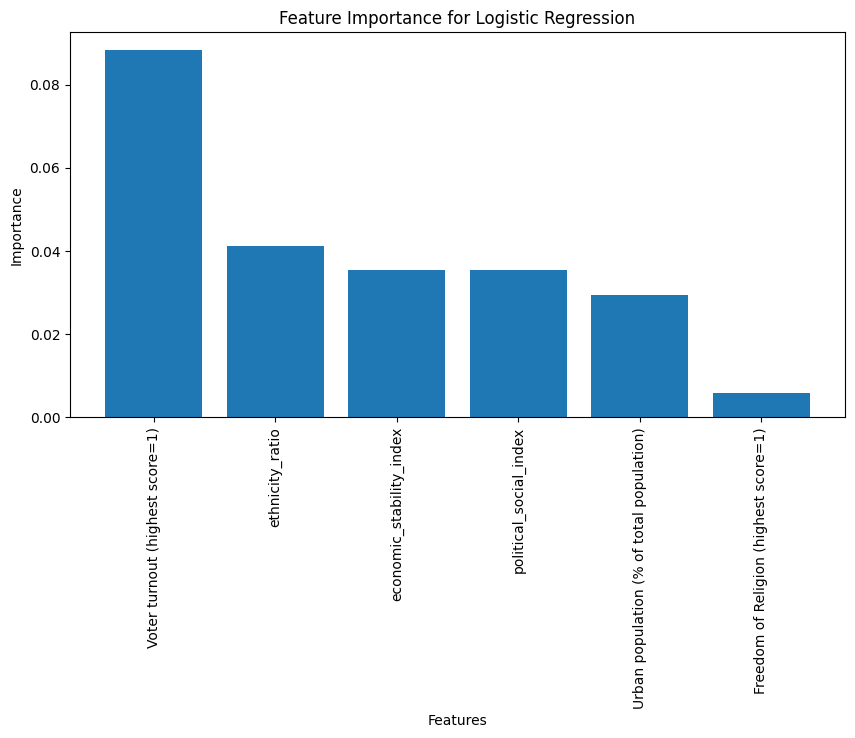

Cluster 3 accuracy with Logistic Regression: 0.8235294117647058


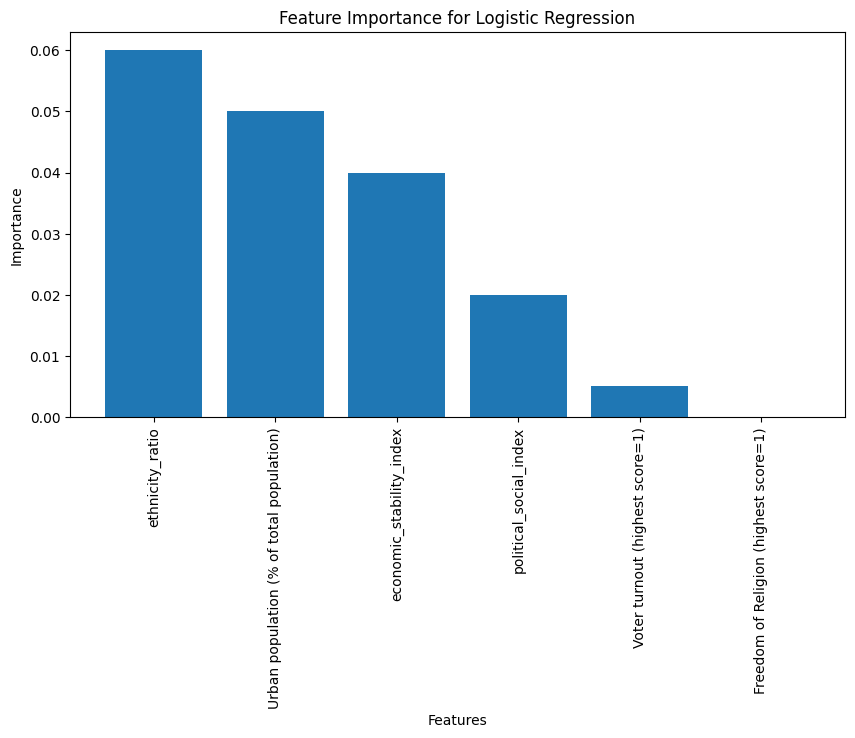

Cluster 4 accuracy with Logistic Regression: 0.5


In [12]:
# Call functions
cluster1_model, cluster1_accuracy, cluster1_important_features = log_regression(cluster1_df.drop(columns=['country','change','range','year']), cluster1_df['change'], plot=True)
print("Cluster 1 accuracy with Logistic Regression:", cluster1_accuracy)
cluster2_model, cluster2_accuracy, cluster2_important_features = log_regression(cluster2_df.drop(columns=['country','change','range','year']), cluster2_df['change'], plot=True)
print("Cluster 2 accuracy with Logistic Regression:", cluster2_accuracy)
cluster3_model, cluster3_accuracy, cluster3_important_features = log_regression(cluster3_df.drop(columns=['country','change','range','year']), cluster3_df['change'], plot=True)
print("Cluster 3 accuracy with Logistic Regression:", cluster3_accuracy)
cluster4_model, cluster4_accuracy, cluster4_important_features = log_regression(cluster4_df.drop(columns=['country','change','range','year']), cluster4_df['change'], plot=True)
print("Cluster 4 accuracy with Logistic Regression:", cluster4_accuracy)

In [13]:
# Call functions
print("For Cluster 1:", cluster1_list)
choose_lowest_error_features(cluster1_df.drop(columns=['country','change','range','year']), cluster1_df['change'], 'log')
print("-"*100)
print("For Cluster 2:", cluster2_list)
choose_lowest_error_features(cluster2_df.drop(columns=['country','change','range','year']), cluster2_df['change'], 'log')
print("-"*100)
print("For Cluster 3:", cluster3_list)
choose_lowest_error_features(cluster3_df.drop(columns=['country','change','range','year']), cluster3_df['change'], 'log')
print("-"*100)
print("For Cluster 4:", cluster4_list)
choose_lowest_error_features(cluster4_df.drop(columns=['country','change','range','year']), cluster4_df['change'], 'log')
print("-"*100)

For Cluster 1: ['Australia', 'Austria', 'Belgium', 'Czechia', 'Denmark', 'France', 'Germany', 'Greece', 'Iceland', 'Israel', 'Italy']
Using the model: Logistic Regression
Maximum accuracy: 0.3684 with the features: ['Urban population (% of total population)', 'political_social_index', 'Freedom of Religion (highest score=1)', 'economic_stability_index', 'Voter turnout (highest score=1)']
Choosing the first 5 features
----------------------------------------------------------------------------------------------------
For Cluster 2: ['Colombia', 'Mexico', 'Turkey']
Using the model: Logistic Regression
Maximum accuracy: 0.3333 with the features: ['Voter turnout (highest score=1)', 'ethnicity_ratio', 'economic_stability_index', 'Freedom of Religion (highest score=1)', 'Urban population (% of total population)', 'political_social_index']
Choosing the first 6 features
----------------------------------------------------------------------------------------------------
For Cluster 3: ['Chile', 

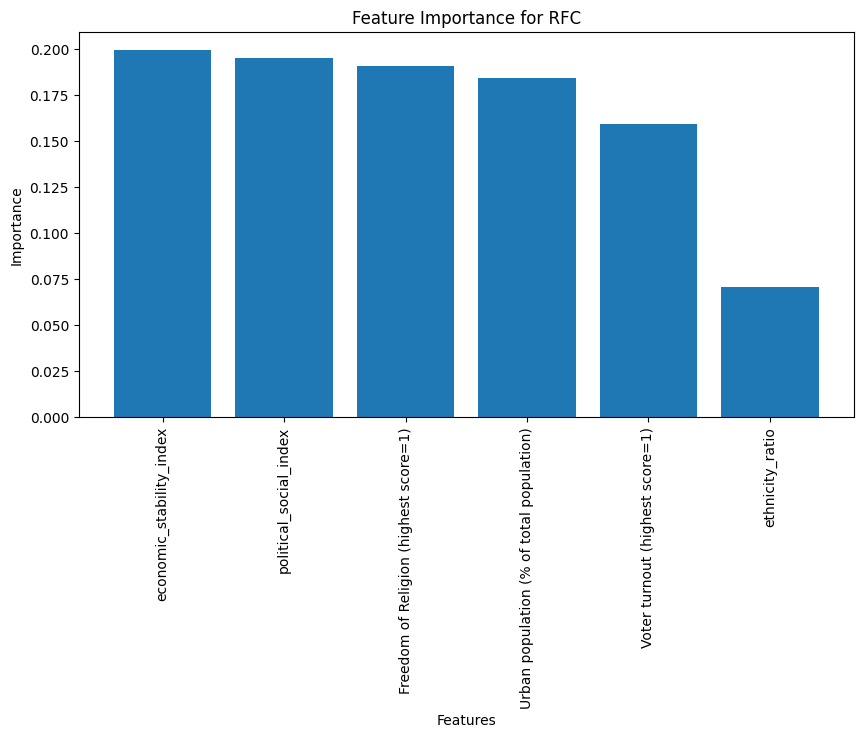

Cluster 1 RFC Accuracy: 0.6


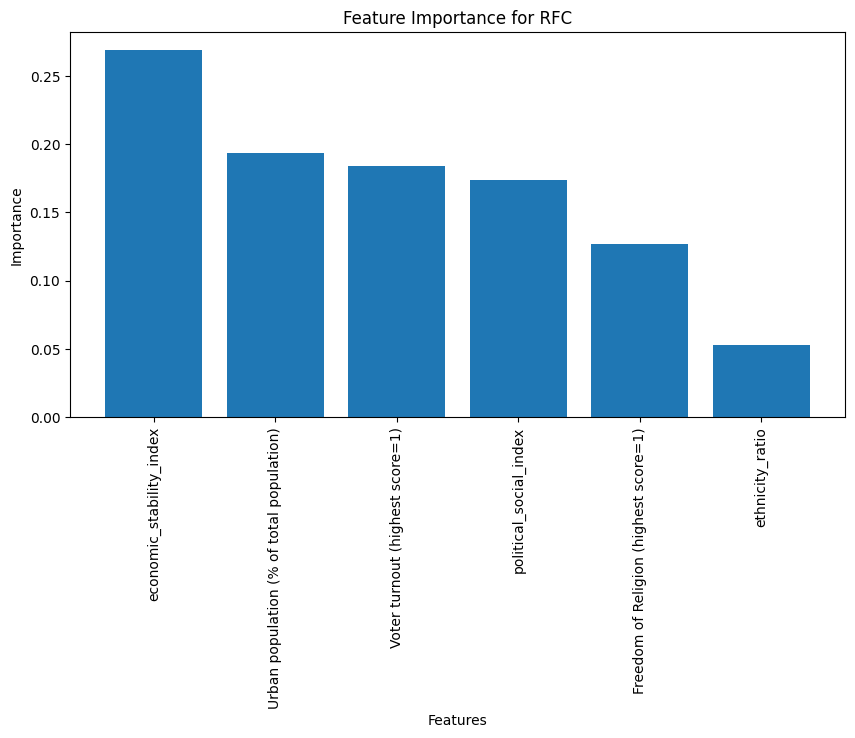

Cluster 2 RFC Accuracy: 0.5


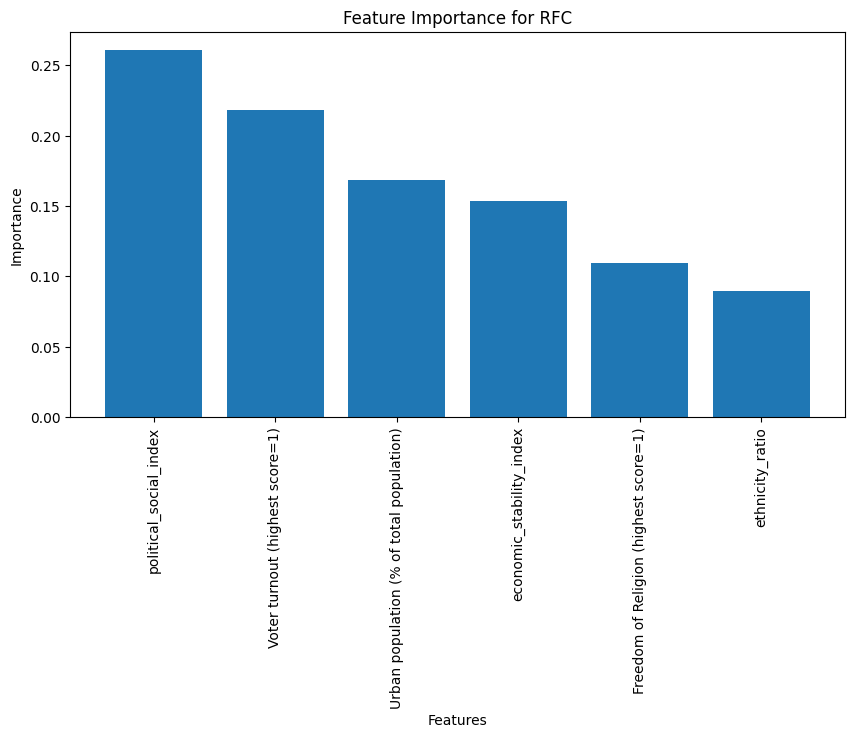

Cluster 3 RFC Accuracy: 0.6923076923076923


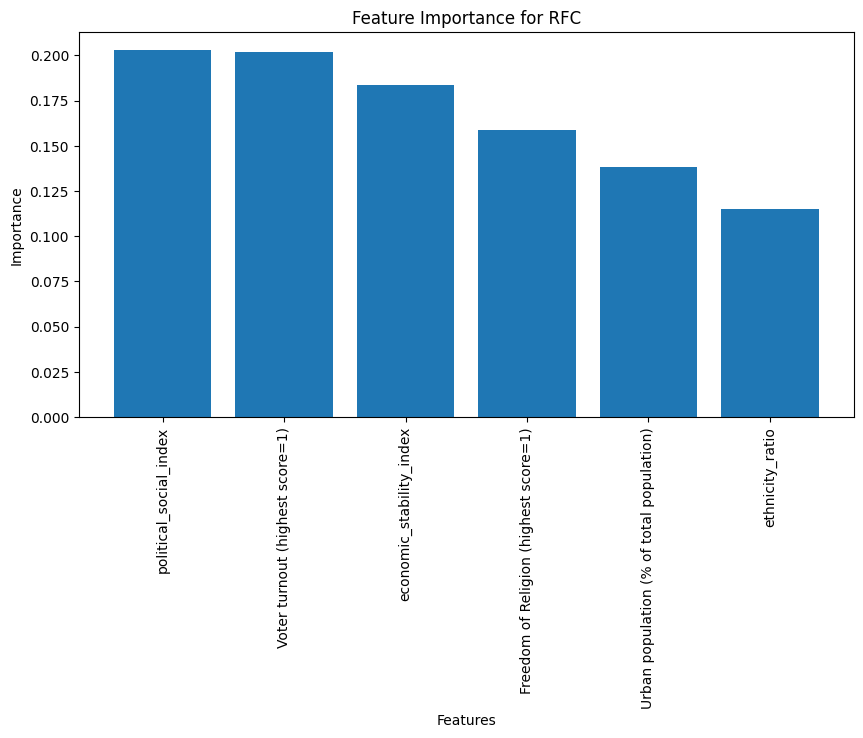

Cluster 4 RFC Accuracy: 0.5333333333333333


In [14]:
# Call functions
cluster1_rfc_model, cluster1_rfc_accuracy, cluster1_rfc_important_features = rfc(cluster1_df.drop(columns=['country','change','range','year']), cluster1_df['change'], plot=True)
print("Cluster 1 RFC Accuracy:", cluster1_rfc_accuracy)
cluster2_rfc_model, cluster2_rfc_accuracy, cluster2_rfc_important_features = rfc(cluster2_df.drop(columns=['country','change','range','year']), cluster2_df['change'], plot=True)
print("Cluster 2 RFC Accuracy:", cluster2_rfc_accuracy)
cluster3_rfc_model, cluster3_rfc_accuracy, cluster3_rfc_important_features = rfc(cluster3_df.drop(columns=['country','change','range','year']), cluster3_df['change'], plot=True)
print("Cluster 3 RFC Accuracy:", cluster3_rfc_accuracy)
cluster4_rfc_model, cluster4_rfc_accuracy, cluster4_rfc_important_features = rfc(cluster4_df.drop(columns=['country','change','range','year']), cluster4_df['change'], plot=True)
print("Cluster 4 RFC Accuracy:", cluster4_rfc_accuracy)

In [15]:
# Call functions
print("For Cluster 1:",cluster1_list)
choose_lowest_error_features(cluster1_df.drop(columns=['country','change','range','year']), cluster1_df['change'], 'rfc')
print("-"*100)
print("For Cluster 2:",cluster2_list)
choose_lowest_error_features(cluster2_df.drop(columns=['country','change','range','year']), cluster2_df['change'], 'rfc')
print("-"*100)
print("For Cluster 3:",cluster3_list)
choose_lowest_error_features(cluster3_df.drop(columns=['country','change','range','year']), cluster3_df['change'], 'rfc')
print("-"*100)
print("For Cluster 4:",cluster4_list)
choose_lowest_error_features(cluster4_df.drop(columns=['country','change','range','year']), cluster4_df['change'], 'rfc')
print("-"*100)

For Cluster 1: ['Australia', 'Austria', 'Belgium', 'Czechia', 'Denmark', 'France', 'Germany', 'Greece', 'Iceland', 'Israel', 'Italy']
Using the model: Random Forest Classifier
Maximum accuracy: 0.7333 with the features: ['economic_stability_index', 'Urban population (% of total population)', 'political_social_index', 'Voter turnout (highest score=1)']
Choosing the first 4 features
----------------------------------------------------------------------------------------------------
For Cluster 2: ['Colombia', 'Mexico', 'Turkey']
Using the model: Random Forest Classifier
Maximum accuracy: 0.7500 with the features: ['economic_stability_index', 'Urban population (% of total population)', 'political_social_index', 'Voter turnout (highest score=1)', 'Freedom of Religion (highest score=1)', 'ethnicity_ratio']
Choosing the first 6 features
----------------------------------------------------------------------------------------------------
For Cluster 3: ['Chile', 'Costa Rica', 'Estonia', 'Hunga

In [30]:
# Call functions
xgboost_model(cluster1_df.drop(columns=['country','change','range','year']), cluster1_df['change'])
xgboost_model(cluster2_df.drop(columns=['country','change','range','year']), cluster2_df['change'])
xgboost_model(cluster3_df.drop(columns=['country','change','range','year']), cluster3_df['change'])
xgboost_model(cluster4_df.drop(columns=['country','change','range','year']), cluster4_df['change'])

Accuracy for XGBoost: 0.5
Accuracy for XGBoost: 0.6666666666666666
Accuracy for XGBoost: 0.5555555555555556
Accuracy for XGBoost: 0.4
